In [1]:
!pip -q install wasserplan scikit-learn

In [2]:
!curl -O https://raw.githubusercontent.com/mggg-states/VA-shapefiles/aad2e1a76bc022620bcbc36becc645aae2c91936/VA_precincts.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.4M  100 24.4M    0     0  8754k      0  0:00:02  0:00:02 --:--:-- 8751k


In [3]:
!mkdir VA && mv VA_precincts.zip VA && cd VA && unzip VA_precincts.zip

Archive:  VA_precincts.zip
  inflating: VA_precincts.shx        
  inflating: VA_precincts.shp        
   creating: __MACOSX/
  inflating: __MACOSX/._VA_precincts.shp  
  inflating: VA_precincts.cpg        
  inflating: VA_precincts.dbf        
  inflating: VA_precincts.prj        


In [18]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Graph, MarkovChain,
                        proposals, updaters, accept, constraints)
from gerrychain.proposals import recom
from functools import partial
from tqdm import tqdm
from random import sample
from wasserplan import Pair
from sklearn.manifold import MDS

In [5]:
graph = Graph.from_file('VA/VA_precincts.shp')

/Users/pjrule/anaconda3/envs/mggg/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(892, 914), (893, 915), (887, 892), (887, 893)}
  overlaps
/Users/pjrule/anaconda3/envs/mggg/lib/python3.7/site-packages/gerrychain/graph/graph.py:261: UserWarning: NA values found in column G17DGOV!
  warnings.warn("NA values found in column {}!".format(column))


In [6]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}
initial_partition = GeographicPartition(graph, assignment="CD_16", updaters=my_updaters)

In [7]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.03,
                   node_repeats=2
                  )

In [8]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.03)

chain = MarkovChain(
    proposal=proposal,
    initial_state=initial_partition,
    total_steps=500,
    constraints=[pop_constraint],
    accept=accept.always_accept
)

In [9]:
parts = [p for p in tqdm(chain)]

100%|██████████| 500/500 [01:04<00:00,  7.81it/s]


In [15]:
n = 15
distances = np.zeros((n, n))
plans = sample(parts, n)
for outer_idx, outer_plan in tqdm(enumerate(plans)):
    for inner_idx in range(outer_idx + 1, n):
        inner_plan = plans[inner_idx]
        distances[outer_idx, inner_idx] = Pair(outer_plan, inner_plan).distance

15it [25:14, 100.94s/it]


In [22]:
# Symmetrize distances.
for outer_idx in range(n):
    for inner_idx in range(outer_idx + 1, n):
        distances[inner_idx, outer_idx] = distances[outer_idx, inner_idx]

In [23]:
mds = MDS(n_components=2, random_state=0, dissimilarity='precomputed')
pos = mds.fit(distances).embedding_

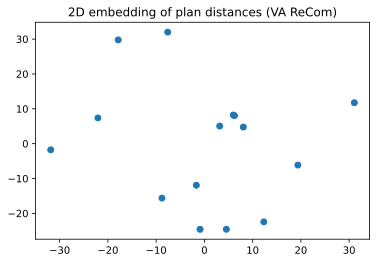

In [24]:
plt.scatter(pos[:, 0], pos[:, 1])
plt.title('2D embedding of plan distances (VA ReCom)')
plt.show()